# Data Exploration
Download and explore the stocks data from Yahoo finance api

# LSTM 
## Import the required libraries for model.

In [1]:
import numpy 
import matplotlib.pyplot as plt
import pandas 
from pandas_datareader import data
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline

Using TensorFlow backend.


## Define function to download the data from Yahoo Finance

In [2]:
def download_data_from_yahoo(tickers, start_date, end_date):
    '''
    Expect 3 arguments to this function
    tickers => list of tickers e.g ['YHO', 'MSFT']
    start_date => 'YYYY-MM-DD'
    end_date => 'YYYY-MM-DD'
    
    '''
    
    # Define the instruments to download.
    _tickers = tickers

    # Define which online source one should use
    _data_source = 'yahoo'

    # Download the data between start_date and end_date
    _start_date = start_date
    _end_date = end_date

    # User pandas_reader.data.DataReader to download the desired data. 
    panel_data = data.DataReader(_tickers, _data_source, _start_date, _end_date)
    
    # Convert to pandas dataframe
    df = panel_data.to_frame()
    
    # Sort the data based on date in ascendating order i.e oldest date first
    df = df.sort_index(ascending=True)
    
    # Drop 'Close' in favor or Adj Close
    df.drop('Close', axis=1, inplace=True)
    
    # Rename 'Adj Close' => 'Close'
    df = df.rename(columns={'Adj Close': 'Close'})
    
    # Move 'Open' column to the right most
    df = df[['Close', 'High', 'Low', 'Volume','Open']]
    
    return df

In [3]:
ticker='TSLA'
df = download_data_from_yahoo([ticker], '2016-01-01','2017-09-30' )
df.head()

,,Close,High,Low,Volume,Open
Date,minor,,,,,
2015-12-31,TSLA,240.009995,243.449997,238.369995,2715000.0,238.509995
2016-01-04,TSLA,223.410004,231.380005,219.000000,6827100.0,230.720001
2016-01-05,TSLA,223.429993,226.889999,220.000000,3186800.0,226.360001
2016-01-06,TSLA,219.039993,220.050003,215.979996,3779100.0,220.000000
2016-01-07,TSLA,215.649994,218.440002,213.669998,3554300.0,214.190002


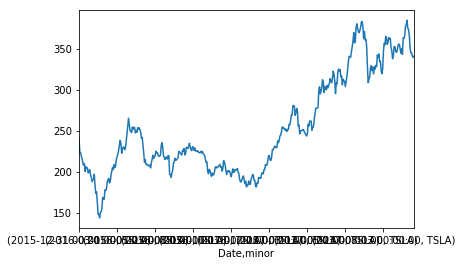

In [4]:
df.Close.plot()

In [5]:
#df.info()

In [6]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [7]:
# load the dataset
dataset = df.values
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 441 entries, (2015-12-31 00:00:00, TSLA) to (2017-09-29 00:00:00, TSLA)
Data columns (total 5 columns):
Close     441 non-null float64
High      441 non-null float64
Low       441 non-null float64
Volume    441 non-null float64
Open      441 non-null float64
dtypes: float64(5)
memory usage: 22.1+ KB


In [8]:
dataset[:10]

array([[  2.40009995e+02,   2.43449997e+02,   2.38369995e+02,
          2.71500000e+06,   2.38509995e+02],
       [  2.23410004e+02,   2.31380005e+02,   2.19000000e+02,
          6.82710000e+06,   2.30720001e+02],
       [  2.23429993e+02,   2.26889999e+02,   2.20000000e+02,
          3.18680000e+06,   2.26360001e+02],
       [  2.19039993e+02,   2.20050003e+02,   2.15979996e+02,
          3.77910000e+06,   2.20000000e+02],
       [  2.15649994e+02,   2.18440002e+02,   2.13669998e+02,
          3.55430000e+06,   2.14190002e+02],
       [  2.11000000e+02,   2.20440002e+02,   2.10770004e+02,
          3.62810000e+06,   2.17860001e+02],
       [  2.07850006e+02,   2.14449997e+02,   2.03000000e+02,
          4.08970000e+06,   2.14009995e+02],
       [  2.09970001e+02,   2.13740005e+02,   2.05309998e+02,
          3.09190000e+06,   2.11600006e+02],
       [  2.00309998e+02,   2.12649994e+02,   2.00000000e+02,
          4.12640000e+06,   2.12009995e+02],
       [  2.06179993e+02,   2.1000000

## Split data into train (80%) and test (20%) dataset 

In [9]:
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print("Total dataset %s => %s [train dataset] + %s [test dataset]" %(len(dataset), len(train), len(test)))

Total dataset 441 => 352 [train dataset] + 89 [test dataset]


In [10]:
features = df.columns
no_of_features = len(features)
print(no_of_features)
# Reshape the dataset into X=t and Y=t+1
'''
X include ['Close', 'High', 'Low', 'Volume'] from time t
Y use 'Open' from the next day i.e time t+1 as the prediction price for next day
'''
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0:4]
        dataX.append(a.ravel())  # flatten the [[]] double nested list into a [] list
        dataY.append(dataset[i + look_back, 4]) # Take next day 'Open' price as Y value
    return numpy.array(dataX), numpy.array(dataY)

5


In [11]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [12]:
print(trainX[:3])
print(trainY[:3])

[[  2.40009995e+02   2.43449997e+02   2.38369995e+02   2.71500000e+06]
 [  2.23410004e+02   2.31380005e+02   2.19000000e+02   6.82710000e+06]
 [  2.23429993e+02   2.26889999e+02   2.20000000e+02   3.18680000e+06]]
[ 230.720001  226.360001  220.      ]


## Normalize the dataset

In [13]:
print("Before normalizing the data.\n", trainX[:3])
print(trainY[:3])
# X and Y have different numpy shape and hence defining 2 scaler
x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

trainX = x_scaler.fit_transform(trainX)
trainY = y_scaler.fit_transform(trainY.reshape(-1,1))

testX = x_scaler.fit_transform(testX)
testY = y_scaler.fit_transform(testY.reshape(-1,1))
print("\nAfter normalizing the data.\n", trainX[:3])
print(trainY[:3])

Before normalizing the data.
 [[  2.40009995e+02   2.43449997e+02   2.38369995e+02   2.71500000e+06]
 [  2.23410004e+02   2.31380005e+02   2.19000000e+02   6.82710000e+06]
 [  2.23429993e+02   2.26889999e+02   2.20000000e+02   3.18680000e+06]]
[ 230.720001  226.360001  220.      ]

After normalizing the data.
 [[ 0.53065269  0.51236316  0.53922869  0.04779716]
 [ 0.43921787  0.44246918  0.43190381  0.23400912]
 [ 0.43932797  0.4164688   0.43744459  0.06916211]]
[[ 0.48263809]
 [ 0.45883376]
 [ 0.42411002]]


In [14]:
test=numpy.array([ 230.720001,  226.360001, 220.])
print(test)
transformed_test = y_scaler.fit_transform(test.reshape(-1,1))
print(transformed_test)
#[ 230.720001  226.360001  220.      ]
#test2 = y_scaler.inverse_transform(transformed_test)
#print(test2)

[ 230.720001  226.360001  220.      ]
[[ 1.        ]
 [ 0.59328362]
 [ 0.        ]]


In [15]:
trainX[:3].shape, trainY[:3].shape

((3, 4), (3, 1))

In [16]:
trainX[:3], trainY[:3]

(array([[ 0.53065269,  0.51236316,  0.53922869,  0.04779716],
        [ 0.43921787,  0.44246918,  0.43190381,  0.23400912],
        [ 0.43932797,  0.4164688 ,  0.43744459,  0.06916211]]),
 array([[ 0.48263809],
        [ 0.45883376],
        [ 0.42411002]]))

In [17]:
# A quick view of the X and Y
#numpy.hstack((trainX[:3], trainY[:3].reshape(3,1)))

In [18]:
# reshape input to be [samples, time steps, features]
print(trainX[:3])
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX[:].shape)
print(testX[:].shape)

[[ 0.53065269  0.51236316  0.53922869  0.04779716]
 [ 0.43921787  0.44246918  0.43190381  0.23400912]
 [ 0.43932797  0.4164688   0.43744459  0.06916211]]
(350, 1, 4)
(87, 1, 4)


In [19]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1,4)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
2s - loss: 0.1090
Epoch 2/100
2s - loss: 0.0138
Epoch 3/100
2s - loss: 0.0065
Epoch 4/100
2s - loss: 0.0023
Epoch 5/100
2s - loss: 8.7423e-04
Epoch 6/100
2s - loss: 6.0541e-04
Epoch 7/100
2s - loss: 5.5043e-04
Epoch 8/100
2s - loss: 5.0323e-04
Epoch 9/100
2s - loss: 4.7756e-04
Epoch 10/100
3s - loss: 4.4526e-04
Epoch 11/100
2s - loss: 4.2644e-04
Epoch 12/100
2s - loss: 4.1058e-04
Epoch 13/100
2s - loss: 3.9035e-04
Epoch 14/100
2s - loss: 3.9993e-04
Epoch 15/100
3s - loss: 3.8447e-04
Epoch 16/100
3s - loss: 3.9241e-04
Epoch 17/100
3s - loss: 3.9386e-04
Epoch 18/100
2s - loss: 3.7428e-04
Epoch 19/100
2s - loss: 3.7468e-04
Epoch 20/100
2s - loss: 3.6709e-04
Epoch 21/100
2s - loss: 3.6534e-04
Epoch 22/100
2s - loss: 3.6609e-04
Epoch 23/100
2s - loss: 3.6949e-04
Epoch 24/100
2s - loss: 3.6828e-04
Epoch 25/100
2s - loss: 3.8223e-04
Epoch 26/100
2s - loss: 3.7107e-04
Epoch 27/100
2s - loss: 3.6777e-04
Epoch 28/100
2s - loss: 3.5536e-04
Epoch 29/100
2s - loss: 3.5727e-04
Epoch 30/1

## Make prediction with test data

In [20]:
print(trainX[:3])

[[[ 0.53065269  0.51236316  0.53922869  0.04779716]]

 [[ 0.43921787  0.44246918  0.43190381  0.23400912]]

 [[ 0.43932797  0.4164688   0.43744459  0.06916211]]]


In [21]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [22]:
print('Compare trainY and trainPredict')
print(trainY.shape, trainPredict.shape)
print(numpy.hstack((trainY[:5],trainPredict[:5])))
print('\nCompare testY and testPredict')
print(testY.shape, testPredict.shape)
print(numpy.hstack((testY[:5],testPredict[:5])))


Compare trainY and trainPredict
(350, 1) (350, 1)
[[ 0.48263809  0.53289986]
 [ 0.45883376  0.44255674]
 [ 0.42411002  0.44054258]
 [ 0.39238913  0.41394705]
 [ 0.41242625  0.39794594]]

Compare testY and testPredict
(87, 1) (87, 1)
[[ 0.0593577   0.10342973]
 [ 0.17753089  0.19849274]
 [ 0.33595345  0.32785302]
 [ 0.42146636  0.41191578]
 [ 0.36414138  0.41619456]]


## Reshape and invert the transformation

In [23]:
print(trainY[:3])
trainY2 = y_scaler.inverse_transform(trainY)
trainY2[:3]

[[ 0.48263809]
 [ 0.45883376]
 [ 0.42411002]]


array([[ 225.17388078],
       [ 224.91869841],
       [ 224.54645984]])

In [34]:
#[ 230.720001  226.360001  220. ]
# This is to test that the y_scaler is inverse_transforming back correctly
print(transformed_test)
test2 = y_scaler.inverse_transform(transformed_test)
print(test2)

[[ 1.        ]
 [ 0.59328362]
 [ 0.        ]]
[[ 230.720001]
 [ 226.360001]
 [ 220.      ]]


In [25]:
# Reshape to (350,5) as this is the numpy array shape when we did the transformed earlier.
#trainPredict2 = numpy.hstack((trainX[:].reshape(len(trainX),4), trainPredict[:].reshape(len(trainPredict),1)))
#trainY2 = numpy.hstack((trainX[:].reshape(len(trainX),4), trainY[:].reshape(len(trainY),1)))
#testPredict2  = numpy.hstack((testX[:].reshape(len(testX),4), testPredict[:].reshape(len(testPredict),1)))
#testY2 = numpy.hstack((testX[:].reshape(len(testX),4), testY[:].reshape(len(testY),1)))

#print(trainPredict2.shape)
#print(trainY2.shape)
#print(testPredict2.shape)
#print(trainY2.shape)

# Transform back to original matrixs
trainPredict2 = y_scaler.inverse_transform(trainPredict)
trainY2 = y_scaler.inverse_transform(trainY)
testPredict2 = y_scaler.inverse_transform(testPredict)
testY2 = y_scaler.inverse_transform(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.02 RMSE
Test Score: 0.06 RMSE


In [40]:
trainY2.shape


(350, 1)

In [49]:
train[1:-1,4].reshape(-1,1).shape

(350, 1)

In [44]:
dataset[0:train_size,4].reshape(-1,1).shape

(352, 1)

In [51]:
print('Compare trainY and trainPredict')
print(numpy.hstack((train[1:-1,4].reshape(-1,1),trainY2,trainPredict2)))
print('\nCompare testY and testPredict')
print(numpy.hstack((testY2,testPredict2)))

Compare trainY and trainPredict
[[ 230.720001    225.17388078  225.71269226]
 [ 226.360001    224.91869841  224.74420166]
 [ 220.          224.54645984  224.72261047]
 ..., 
 [ 315.5         230.13589025  229.89918518]
 [ 312.799988    229.97786376  229.86012268]
 [ 310.459991    229.84090826  229.79808044]]

Compare testY and testPredict
[[ 220.63631458  221.10876465]
 [ 221.90313135  222.12783813]
 [ 223.60142135  223.5145874 ]
 [ 224.51811979  224.41572571]
 [ 223.90359591  224.46160889]
 [ 223.71909554  224.35296631]
 [ 224.61981553  225.19642639]
 [ 226.31083906  226.1192627 ]
 [ 227.38734322  227.06471252]
 [ 228.93745214  228.46722412]
 [ 226.55054546  227.24661255]
 [ 227.94956501  227.04016113]
 [ 229.90644817  229.24734497]
 [ 228.65851815  230.03955078]
 [ 229.45463846  229.16960144]
 [ 229.02171099  228.88909912]
 [ 229.2643257   228.66725159]
 [ 228.92728173  228.99291992]
 [ 229.45608818  229.31825256]
 [ 230.1040274   230.20881653]
 [ 230.720001    230.40870667]
 [ 229.2

In [38]:
print(dataset[:3])

[[  2.40009995e+02   2.43449997e+02   2.38369995e+02   2.71500000e+06
    2.38509995e+02]
 [  2.23410004e+02   2.31380005e+02   2.19000000e+02   6.82710000e+06
    2.30720001e+02]
 [  2.23429993e+02   2.26889999e+02   2.20000000e+02   3.18680000e+06
    2.26360001e+02]]


[[ 238.509995]
 [ 230.720001]
 [ 226.360001]
 [ 220.      ]
 [ 214.190002]]
(441, 1)
(441, 1)
[[          nan]
 [ 225.71269226]
 [ 224.74420166]
 [ 224.72261047]
 [ 224.4375    ]
 [ 224.26597595]
 [ 224.0749054 ]
 [ 223.82395935]
 [ 223.92697144]
 [ 223.4777832 ]]


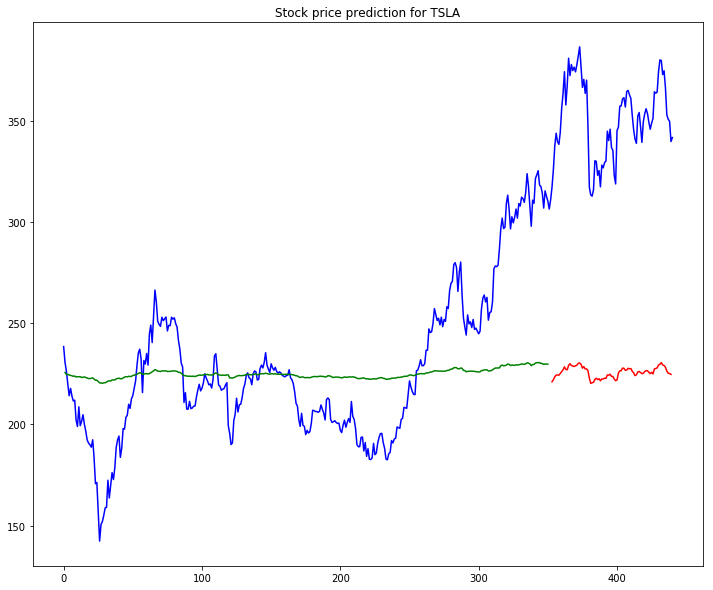

In [36]:
# Extract the 'Open' price from the original dataset
datasetPlot= dataset[:,4]
datasetPlot = datasetPlot.reshape(len(datasetPlot),1)
print(datasetPlot[:5])
print(datasetPlot.shape)
#datasetplot.reshape(len(datasetplot,1))

#print(trainPredict[:3])
trainPredictPlot = numpy.empty_like(datasetPlot)
trainPredictPlot[:, :] = numpy.nan
#print(trainPredict4[:3])
trainPredictPlot[look_back:len(trainPredict2)+look_back, :] = trainPredict2
print(trainPredictPlot.shape)
print(trainPredictPlot[:10])

#print(numpy.hstack((datasetPlot,trainPredict2)))

#print(dataset.shape)
#print(testPredict3.shape)
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(datasetPlot)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict2)+(look_back*2)+1:len(dataset)-1, :] = testPredict2
# plot baseline and predictions
plt.figure(figsize=(12,10))
plt.plot(datasetPlot, color='blue', label='Historic Data')
plt.plot(trainPredictPlot, color='green', label='Training Data')
plt.plot(testPredictPlot, color='red', label='Prediction Data')
plt.title('Stock price prediction for %s' %ticker)
plt.show()


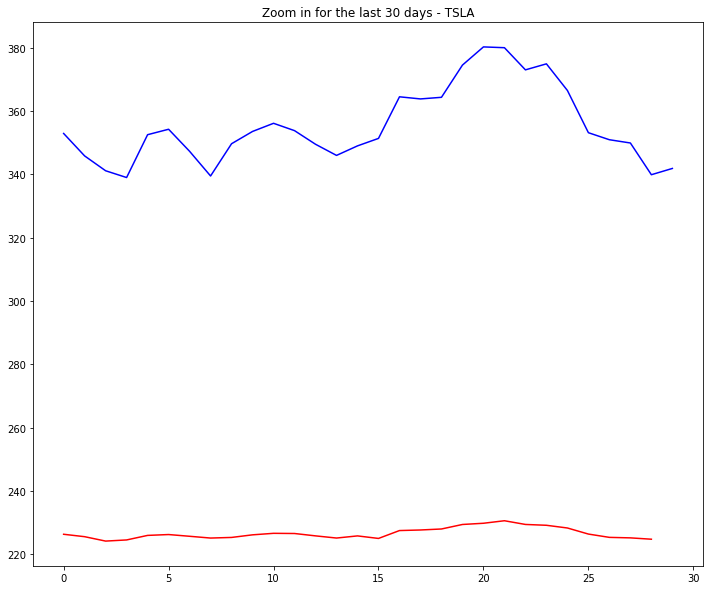

In [32]:
plt.figure(figsize=(12,10))
plt.plot(datasetPlot[-30:], color='blue', label='Historic Data')
plt.plot(testPredictPlot[-30:], color='red', label='Prediction Data')
plt.title("Zoom in for the last 30 days - %s" %ticker)
plt.show()